# Assignment 1 - Testing CAPM (GRS, 1989) (Jaakko Wallenius, Quantitative Finance 28E35600)

**Note**: Pandas may fail when using Windows os due to memory allocation limitation (raises **MemoryError**). In case this happens, rerun the code. More on this:

https://stackoverflow.com/questions/17557074/memory-error-when-using-pandas-read-csv

In [1]:
%%capture
%run data.ipynb # The datasets are imported and prepared in the data notebook

In [2]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

### For speed: multiprocessing

To speed up the code I use **multiprocessing** for parallelized computation. Computation speed is affected by the number of cores available.

In [3]:
import multiprocessing as mp
from multiprocessing.pool import ThreadPool

In [4]:
print('Number of cores available: {}'.format(mp.cpu_count()))

Number of cores available: 16


In [5]:
def threadify(f, arr):
    # Maps array with function f parallelized
    pool = ThreadPool(mp.cpu_count())
    result = pool.map(f,arr)
    pool.terminate()
    pool.join()
    return result

## Forming portfolios

Form 20 portfolios based on market values of the stock. I use U.S. Research Breakpoints (https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html). Portfolios are rebalanced monthly.

In [6]:
# form_portfolios is the 'public' function which returns assigned data (data with PORT variable, i.e. the
# assigned portfolio for the stock given breakpoints for the date).
# Other functions are helpers.

from bisect import bisect

def assign_portfolio(breakpoints,date,me):
    # Helper for portfolios_for_date
    # Returns the number of portfolio (Smallest 1, ... , Largest 20)
    # to which the stock belongs given its market value (me) and date
    pos = 1
    bp = breakpoints.loc[breakpoints['date'] == date][range(2,22)].values.flatten()
    pos = bisect(bp,me) + 1
    if pos > 20: pos = 20 # This can be a problem since 100% percentile is of NYSE (not of all, i.e. NASDAQ)
    return pos

import time

def portfolios_for_date(data,breakpoints,date):
    # Helper for form_portfolios
    # For a date (month) assigns stocks into portfolios based on market value and the date's breakpoints.
    df = data.loc[data['date'] == date]
    df['PORT'] = df['ME'].map(lambda e: assign_portfolio(breakpoints,date,e))
    print('.', end='')
    return df

def form_portfolios(data,months,breakpoints):
    # Returns DataFrame where each stock is assigned into ME portfolio given the breakpoints
    # for the date.
    start = time.time()
    print('Progress')
    dfs = threadify(lambda d: portfolios_for_date(data,breakpoints,d),months)
    print('Done. Execution time: {}s'.format(round(time.time()-start,3)))
    return pd.concat(dfs, ignore_index=True)

In [7]:
def portfolios_summary_month(data,date):
    # Helper for portfolios_summary_table
    return {**{'date':date}, **data.loc[data['date'] == date]['PORT'].value_counts().to_dict()}

def portfolios_summary_table(data,months):
    # Forms a summary table of number of stocks in portfolios
    df = pd.DataFrame(threadify(lambda d: portfolios_summary_month(data,d),months)).set_index('date')
    return df.sort_index(axis=1)

Even parallelized this runs for ~6mins (give or take depending on CPU).

assign_portfolio algorithm is far from optimal and could be made more efficient with some effort. With few empirical tests bisect runs as long as simple for loop, hence its $O(n)$.

In [8]:
portfolios_data = form_portfolios(data,months,breakpoints) # Note: data, months, breakpoints are from data.ipynb

Progress
............................................................Done. Execution time: 317.243s


### Summary table: number of stocks in portfolios

In [9]:
counts_table = portfolios_summary_table(portfolios_data,months)
print_ret_table(counts_table,5,5)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
date,,,,,,,,,,,,,,,,,,,,
201501,870,356,235,192,197,194,172,153,139,113,111,90,113,107,91,87,95,86,82,89
201502,900,351,244,186,203,200,154,147,144,108,103,99,112,106,94,89,89,94,80,91
201503,896,312,279,193,183,209,154,149,142,108,107,98,113,104,89,92,87,91,78,91
201504,905,341,248,195,221,193,153,152,126,106,107,95,118,101,92,86,83,94,79,91
201505,847,375,247,184,226,197,149,150,122,115,103,103,121,96,93,89,87,90,81,89
201908,693,331,281,207,206,132,176,138,134,116,138,94,90,101,101,84,90,89,73,93
201909,712,328,274,231,186,137,152,147,137,108,123,102,90,95,100,87,88,88,71,93
201910,662,345,276,212,205,150,154,143,137,111,118,113,87,108,89,88,88,84,73,93
201911,646,315,275,236,208,161,143,155,126,122,118,108,90,108,91,87,89,83,76,91


## Portfolio returns

In [10]:
def portfolios_returns_month(data,date):
    returns = {}
    portfolios = range(1,21)
    for i in portfolios:
        p_data = data.loc[(data['date'] == date) & (data['PORT'] == i)]
        returns[i] = p_data["RET"].mean()
    return {**{'date':date}, **returns}

def portfolios_returns_table(data,months):
    returns = threadify(lambda e: portfolios_returns_month(data,e),months)
    return pd.DataFrame(returns).set_index('date')

Summary table of portfolios returns.

In [11]:
portfolios_returns = portfolios_returns_table(portfolios_data,months)
portfolios_returns.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,-0.001527,0.009480,0.011512,0.015610,0.013334,0.012732,0.014376,0.015586,0.015130,0.014899,0.013087,0.014217,0.016535,0.014514,0.016611,0.013190,0.013791,0.013213,0.013592,0.012945
std,0.051652,0.051690,0.053238,0.056733,0.055694,0.052918,0.052435,0.049650,0.050520,0.049498,0.047465,0.045063,0.044057,0.044330,0.056639,0.040406,0.037677,0.035866,0.034212,0.034345
min,-0.147521,-0.118158,-0.114044,-0.121453,-0.129441,-0.115950,-0.121652,-0.107733,-0.124334,-0.115918,-0.118307,-0.111720,-0.102482,-0.100953,-0.110593,-0.102563,-0.090136,-0.089894,-0.081819,-0.083726
25%,-0.026579,-0.021179,-0.019870,-0.005143,-0.016389,-0.008561,-0.015418,-0.012308,-0.007488,-0.005652,-0.012565,-0.006465,-0.000103,-0.002036,0.000630,-0.001506,-0.001331,-0.002274,0.000482,-0.000564
50%,0.002420,0.014288,0.015218,0.016743,0.018671,0.022686,0.017997,0.016885,0.016491,0.017590,0.016955,0.014874,0.020705,0.019543,0.012632,0.014208,0.014100,0.013782,0.015542,0.016492
75%,0.022836,0.041647,0.049775,0.055669,0.047586,0.036947,0.041504,0.040010,0.041428,0.045984,0.041738,0.040665,0.038888,0.031785,0.035937,0.032467,0.034722,0.034853,0.030324,0.030266
max,0.200142,0.123981,0.142961,0.142228,0.127971,0.125433,0.142371,0.119338,0.139301,0.120327,0.140604,0.126055,0.132370,0.122915,0.322108,0.102619,0.110873,0.109075,0.097420,0.091629


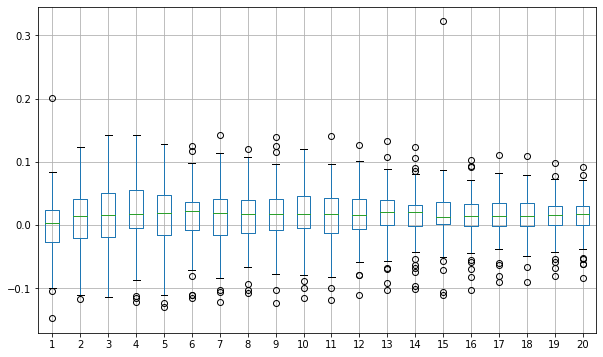

In [12]:
portfolios_returns.boxplot(figsize=(10,6))

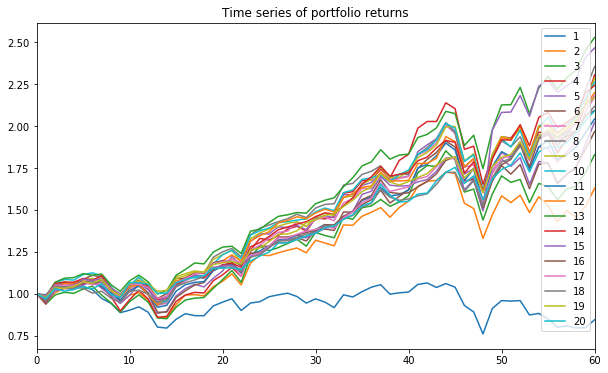

In [13]:
pd.concat([pd.DataFrame(dict(zip(range(1,21), [1]*20)), index=[0]),
           (portfolios_returns[range(1,21)] + 1)
           .cumprod()]).reset_index(drop=True).plot(figsize=(10,6),title='Time series of portfolio returns')

## Time series regressions

The market value portfolios are further analyzed by regressing their return on CAPM. I use data from https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html.
From section "Developed Markets Factors and Returns" file Fama/French North American 5 Factors.

Model:

$R_{i,t}^e=\alpha_i+\beta_iR_{M,t}^e+\epsilon_{i,t}$

Where $R_{i,t}^e=R_{i,t}-R_f:=$ Excess return of portfolio $i$ at time $t$, $R_{M,t}^e=R_{M,t}-R_f:=$ Market excess return

### Data

In [14]:
print_ret_table(factors)

,index,SMB,HML,RMW,CMA,RF,vwret,Mkt-RF
0,2.94,-0.0119,-0.0389,0.0214,-0.0111,0.0000,-0.027201,-0.027201
1,2.95,0.0057,-0.0136,-0.0105,-0.0196,0.0000,0.056021,0.056021
2,2.96,0.0250,-0.0093,0.0000,-0.0056,0.0000,-0.010453,-0.010453
57,3.51,0.0002,-0.0147,0.0105,-0.0094,0.0015,0.019265,0.017765
58,3.52,0.0021,-0.0279,-0.0167,-0.0139,0.0012,0.034971,0.033771
59,3.53,0.0082,0.0143,-0.0020,0.0155,0.0014,0.028448,0.027048


### Results

Subtract RF from the portolio return to get excess return.

In [15]:
excess_returns = portfolios_returns.reset_index().drop('date', 1).apply(lambda portfolio: portfolio-factors['RF'])
excess_returns.columns = excess_returns.columns.map(lambda x: 'P'+str(x))
reg_data = pd.concat([excess_returns,factors],axis=1).rename({'Mkt-RF':'MKT'},axis='columns')
print_ret_table(reg_data)

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,P19,P20,index,SMB,HML,RMW,CMA,RF,vwret,MKT
0,-0.007181,-0.056454,-0.061759,-0.061828,-0.054846,-0.050974,-0.036410,-0.041592,-0.028135,-0.021903,...,-0.024454,-0.029497,2.94,-0.0119,-0.0389,0.0214,-0.0111,0.0000,-0.027201,-0.027201
1,0.054120,0.066331,0.057818,0.101351,0.075195,0.085693,0.065800,0.076293,0.077237,0.087842,...,0.061519,0.060499,2.95,0.0057,-0.0136,-0.0105,-0.0196,0.0000,0.056021,0.056021
2,-0.011916,0.025672,0.015851,0.013954,0.014666,0.034464,0.023158,0.010536,0.024474,0.019990,...,-0.004184,-0.013964,2.96,0.0250,-0.0093,0.0000,-0.0056,0.0000,-0.010453,-0.010453
57,-0.017232,-0.028085,0.008674,0.024486,0.017697,0.025651,0.027965,0.035701,0.035213,0.024409,...,0.025643,0.027270,3.51,0.0002,-0.0147,0.0105,-0.0094,0.0015,0.019265,0.017765
58,0.000727,0.041606,0.046793,0.079444,0.082122,0.057026,0.096180,0.093428,0.038902,0.050472,...,0.038871,0.037712,3.52,0.0021,-0.0279,-0.0167,-0.0139,0.0012,0.034971,0.033771
59,0.057457,0.071032,0.062630,0.081014,0.067746,0.056703,0.041619,0.062131,0.073325,0.044581,...,0.024398,0.027165,3.53,0.0082,0.0143,-0.0020,0.0155,0.0014,0.028448,0.027048


In [16]:
from collections import OrderedDict

def t_alphas_betas_tstats_portfolio(portfolio,data):
    # Helper for regression_result_table
    # Runs regression for each portfolio. Returns model results and residuals.
    capm = ols('P'+str(portfolio) + '~ MKT', data).fit()
    d = {'Portfolio' : portfolio,
         'alpha' : capm.params['Intercept'],
         'alpha t-stat' : capm.tvalues['Intercept'],
         'beta' : capm.params['MKT'],
         'beta t-stat' : capm.tvalues['MKT'],
         'R^2' : capm.rsquared}
    return (OrderedDict(sorted(d.items())), capm.resid)

def regression_result_table(data):
    # Returns results table and models' residuals.
    rows_res = []
    rows_resid = []
    for p in range(1,21):
        reg_res, resid = t_alphas_betas_tstats_portfolio(p,data)
        rows_res.append(reg_res)
        rows_resid.append(resid)
    return (pd.DataFrame(rows_res).set_index('Portfolio'), pd.DataFrame(rows_resid).transpose())

### a. Result table

Note: model residual series for each regression is assigned to variable 'model_resid'

In [17]:
rtable, model_resid = regression_result_table(reg_data)
rtable

,R^2,alpha,alpha t-stat,beta,beta t-stat
Portfolio,,,,,
1,0.610142,-0.011511,-2.669877,1.168323,9.527442
2,0.605732,-0.000478,-0.110263,1.165080,9.439714
3,0.642982,0.000997,0.234423,1.236001,10.220421
4,0.693884,0.004061,0.968068,1.367850,11.466074
5,0.702990,0.001907,0.470037,1.352225,11.716652
6,0.772041,0.001355,0.401182,1.345877,14.015408
7,0.767382,0.003127,0.925135,1.329610,13.832418
8,0.790136,0.004746,1.561624,1.277409,14.777322
9,0.830591,0.003858,1.388811,1.332428,16.863154


### b. Plot

Plots with least squares fitted 1st degree polynomials (for visual)

Text(0, 0.5, 'Mean excess return')

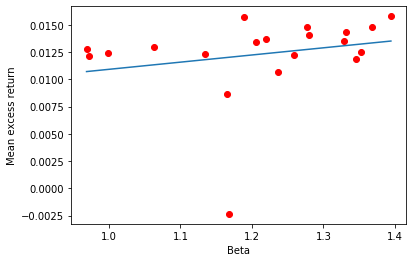

In [18]:
betas = rtable['beta'].values
mean_returns = excess_returns.mean().values

p = np.poly1d(np.polyfit(betas,mean_returns,1))
a = max(betas)
b = min(betas)
lspc = np.linspace(a, b, 100)
plt.plot(betas,mean_returns,'ro',lspc,p(lspc))
plt.xlabel('Beta')
plt.ylabel('Mean excess return')

The data has one clear outlier portfolio (portfolio 1 i.e. smallest stocks). Without the outlier portfolio:

Text(0, 0.5, 'Mean excess return')

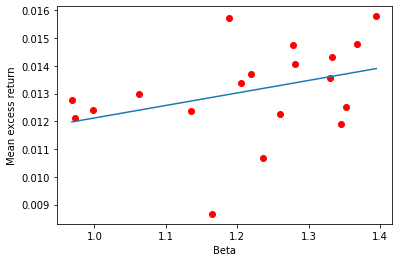

In [19]:
p = np.poly1d(np.polyfit(betas[1:],mean_returns[1:],1))
a = max(betas[1:])
b = min(betas[1:])
lspc = np.linspace(a, b, 100)
plt.plot(betas[1:],mean_returns[1:],'ro',lspc,p(lspc))
plt.xlabel('Beta')
plt.ylabel('Mean excess return')

The pictures indicate some positive relation between beta and excess return.

### c. The GRS statistic

$\frac{T-N-1}{N}\bigg[ 1+\bigg(\frac{\mathbb{E}[f]}{\hat{\sigma}[f]} \bigg)^2 \bigg]^{-1}\hat{\alpha}'\hat{\Sigma}^{-1}\hat{\alpha} \sim F_{N,T-N-1}$

In [20]:
T = 60
N = 20
E_f = factors['Mkt-RF'].mean() # Sample mean of the factor (excess market return)
std_f = factors['Mkt-RF'].std() # Sample standard dev. of the factor (excess market return)
sigma = model_resid.cov().to_numpy() # Unbiased estimate of residual covariance matrix
alpha = rtable['alpha'].values # Estimated intercepts

In [21]:
from scipy.stats import f

def GRS_stat(T,N,E_f,std_f,alpha,sigma):
    g = (T-N-1)/N
    r = (1+(E_f/std_f)**2)**(-1)
    s = np.matmul(np.matmul(alpha,np.linalg.inv(sigma)),alpha)
    F = g*r*s
    # p-value
    df_1 = N
    df_2 = T-N-1
    p_val = f.sf(F, df_1, df_2)
    return (F, p_val)

$H_0:$ $\alpha_i=0 \quad \forall i=1,...,N$

In [22]:
GRS_stat(T,N,E_f,std_f,alpha,sigma)

(5.475627138023899, 3.0076259081162686e-06)

We reject the null hypothesis but we have no alternative hypothesis.

### d. Significant alphas

In [23]:
from scipy.stats import t
rtable['alpha t-stat'].loc[abs(rtable['alpha t-stat']) > t.ppf(0.975,60)].size # 2-tail t-distribution

8

There are $8$ significant alphas (0.05 level)

### e. Discussion

Testing the validity of CAPM using size portfolios and GRS test, the result is that CAPM doesn't hold. 8 of the 20 portfolios produce significant alpha. Interpreting the beta-return plots, it is not clear that there exists strong positive relation between portfolio's beta and mean excess return.

Most importantly the GRS test statistic leads to rejecting the null hypothesis (i.e. CAPM fails to explain the risk-return relation)